# Neural ODE control of $\dot{x}=ax+bu$ with activation

In [32]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib as mpl
from copy import deepcopy
import torch.optim as optim
from torchdiffeq import odeint
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from matplotlib import rcParams

# customized settings
params = {  # 'backend': 'ps',
    'font.family': 'serif',
    'font.serif': 'Latin Modern Roman',
    'font.size': 20,
    'axes.labelsize': 'medium',
    'axes.titlesize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
    'savefig.dpi': 150,
    'text.usetex': True, 
    'legend.title_fontsize': 20}
# tell matplotlib about your params
rcParams.update(params)

# set nice figure sizes
fig_width_pt = 433.62 # Get this from LaTeX using \showthe\columnwidth
golden_mean = (np.sqrt(5.) - 1.) / 2.  # Aesthetic ratio
ratio = golden_mean
inches_per_pt = 1. / 72.27  # Convert pt to inches
fig_width = fig_width_pt * inches_per_pt  # width in inches
fig_height = fig_width*ratio  # height in inches
fig_size = [fig_width,fig_height]
rcParams.update({'figure.figsize': fig_size})

Define time horizon, initial condition, and target state.

In [17]:
T = 1
true_x0 = torch.tensor([0.0])
t = torch.linspace(0., T, 100)
target_x = torch.tensor([1])

Define neural ODE with control term.

In [20]:
class ODE_func(nn.Module):

    def __init__(self,control_output = False):
        super(ODE_func, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(1,5),
           nn.ELU(),
           nn.Linear(5,5),
            nn.ELU(),
            nn.Linear(5,1)
        )
        self.control_output = control_output 
        #self.net = torch.nn.Parameter(torch.tensor([1.0]))

    def forward(self, t, y):
        
        if self.control_output == False:
            return y+self.net(torch.tensor([float(t)]))
        else: 
            return self.net(torch.tensor([float(t)]))

def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.constant_(m.weight,val=1e-1)#kaiming_uniform_(m.weight)
        torch.nn.init.constant_(m.bias,val=1e-1)

Solve control problem.

In [21]:
trajectories = []
net_params = []
learning_rates = [0.1733]#np.linspace(1e-2,5e-1,10)#[0.15]

for eta in learning_rates:
    
    func = ODE_func()
    func.apply(weights_init)

    optimizer = optim.SGD(func.parameters(), lr=eta)

    best_model = func.net
    loss_new = 1e9

    for itr in range(1, 1000):

        optimizer.zero_grad()
        pred_x = odeint(func, true_x0, t, method='dopri5')
        loss = 0.5*torch.abs(pred_x[-1] - target_x)**2
        loss.backward()
        optimizer.step()

        if loss < loss_new:
            best_model = func.net
            loss_new = loss

        if itr % 20 == 0:
            with torch.no_grad():
                pred_x = odeint(func, true_x0, t, method='dopri5')
                loss = 0.5*torch.abs(pred_x[-1] - target_x)**2
                print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
        itr += 1
    
    net_params.append(deepcopy(best_model))
    trajectories.append(pred_x.detach().numpy())

Iter 0020 | Total Loss 0.000000
Iter 0040 | Total Loss 0.000000
Iter 0060 | Total Loss 0.000000
Iter 0080 | Total Loss 0.000000
Iter 0100 | Total Loss 0.000000
Iter 0120 | Total Loss 0.000000
Iter 0140 | Total Loss 0.000000
Iter 0160 | Total Loss 0.000000
Iter 0180 | Total Loss 0.000000
Iter 0200 | Total Loss 0.000000
Iter 0220 | Total Loss 0.000000
Iter 0240 | Total Loss 0.000000
Iter 0260 | Total Loss 0.000000
Iter 0280 | Total Loss 0.000000
Iter 0300 | Total Loss 0.000000
Iter 0320 | Total Loss 0.000000
Iter 0340 | Total Loss 0.000000
Iter 0360 | Total Loss 0.000000
Iter 0380 | Total Loss 0.000000
Iter 0400 | Total Loss 0.000000
Iter 0420 | Total Loss 0.000000
Iter 0440 | Total Loss 0.000000
Iter 0460 | Total Loss 0.000000
Iter 0480 | Total Loss 0.000000
Iter 0500 | Total Loss 0.000000
Iter 0520 | Total Loss 0.000000
Iter 0540 | Total Loss 0.000000
Iter 0560 | Total Loss 0.000000
Iter 0580 | Total Loss 0.000000
Iter 0600 | Total Loss 0.000000
Iter 0620 | Total Loss 0.000000
Iter 064

## 3D loss projections

In [22]:
def mse(x,y):
    return np.linalg.norm(x-y)**2

In [23]:
torch.manual_seed(10)
parameters = []
for i in range(int((len(net_params[0])+1)/2)):
        parameters.append((net_params[0][2*i].weight.size(),net_params[0][2*i].bias.size()))

In [24]:
parameters

[(torch.Size([5, 1]), torch.Size([5])),
 (torch.Size([5, 5]), torch.Size([5])),
 (torch.Size([1, 5]), torch.Size([1]))]

In [25]:
delta = []
eta = []

In [26]:
for i in range(int((len(net_params[0])+1)/2)):
    delta.append([torch.randn(parameters[i][0],requires_grad=True),torch.randn(parameters[i][1],requires_grad=True)])
    eta.append([torch.randn(parameters[i][0],requires_grad=True),torch.randn(parameters[i][1],requires_grad=True)])

In [27]:
def loss_3D(net_params, alpha, beta, delta, eta):
    new_params = deepcopy(net_params[0])
    
    for i in range(int((len(new_params)+1)/2)):
        new_params[2*i].weight = torch.nn.Parameter(new_params[2*i].weight + alpha*delta[i][0] + beta*eta[i][0])
        new_params[2*i].bias = torch.nn.Parameter(new_params[2*i].bias  + alpha*delta[i][1] + beta*eta[i][1])
    
    return new_params

In [30]:
alpha = np.linspace(-0.4,0.4,100)
beta = np.linspace(-0.4,0.4,100)
aa, bb = np.meshgrid(alpha, beta)

loss_alpha_beta = []
mse_u_alpha_beta = []
energy = []

for i in range(len(alpha)):
    print(i,len(alpha))
    for j in range(len(beta)):
        a = aa[i,j]
        b = bb[i,j]
        new_params = loss_3D(net_params, a, b, delta, eta)
        func = ODE_func()
        func.net = new_params
        pred_x = odeint(func, true_x0, t, method='dopri5')
        loss = 0.5*torch.abs(pred_x[-1] - target_x)**2
        loss_alpha_beta.append(float(loss))

        func.control_output = True
        u_hat = np.array([float(func(x,torch.tensor([0.0]))) for x in t])
        mse_u = mse(u_ast(t).detach().numpy(),u_hat)
        mse_u_alpha_beta.append(mse_u)
        energy.append(np.trapz(1/2*u_hat**2,t))
 
mse_u_alpha_beta = np.array(mse_u_alpha_beta).reshape(len(alpha),len(beta))
loss_alpha_beta = np.array(loss_alpha_beta).reshape(len(alpha),len(beta))
energy = np.array(energy).reshape(len(alpha),len(beta))

0 100
1 100
2 100
3 100
4 100
5 100
6 100
7 100
8 100
9 100
10 100
11 100
12 100
13 100
14 100
15 100
16 100
17 100
18 100
19 100
20 100
21 100
22 100
23 100
24 100
25 100
26 100
27 100
28 100
29 100
30 100
31 100
32 100
33 100
34 100
35 100
36 100
37 100
38 100
39 100
40 100
41 100
42 100
43 100
44 100
45 100
46 100
47 100
48 100
49 100
50 100
51 100
52 100
53 100
54 100
55 100
56 100
57 100
58 100
59 100
60 100
61 100
62 100
63 100
64 100
65 100
66 100
67 100
68 100
69 100
70 100
71 100
72 100
73 100
74 100
75 100
76 100
77 100
78 100
79 100
80 100
81 100
82 100
83 100
84 100
85 100
86 100
87 100
88 100
89 100
90 100
91 100
92 100
93 100
94 100
95 100
96 100
97 100
98 100
99 100


In [388]:
# set nice figure sizes
fig_width_pt = 433.62 # Get this from LaTeX using \showthe\columnwidth
golden_mean = (np.sqrt(5.) - 1.) / 2.  # Aesthetic ratio
ratio = golden_mean
inches_per_pt = 1. / 72.27  # Convert pt to inches
fig_width = fig_width_pt * inches_per_pt  # width in inches
fig_height = fig_width*ratio  # height in inches
fig_size = [3*fig_width,1.8*fig_width]
rcParams.update({'figure.figsize': fig_size})

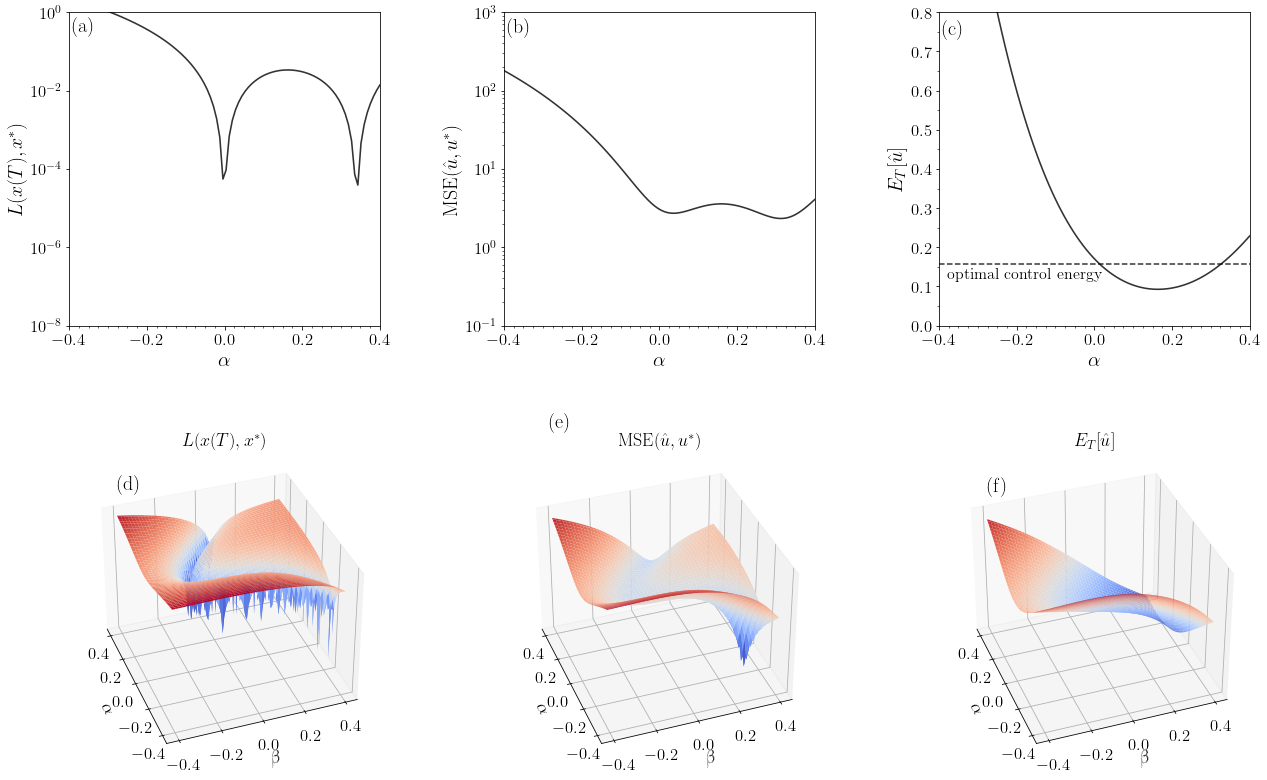

In [33]:
fig, ax = plt.subplots(ncols = 3, nrows = 2)
fig.patch.set_facecolor('white')

ax[1,0].remove()
ax[1,0]=fig.add_subplot(2,3,4,projection='3d')
ax[1,1].remove()
ax[1,1]=fig.add_subplot(2,3,5,projection='3d')
ax[1,2].remove()
ax[1,2]=fig.add_subplot(2,3,6,projection='3d')

text = ax[0,0].text(0.01*0.8-0.4,0.33,r"(a)")
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))
ax[0,0].plot(alpha, loss_alpha_beta[len(mse_u_alpha_beta)//2], color='k', alpha=0.8, linewidth=1.6)
ax[0,0].set_yscale("log")
ax[0,0].set_xlim(-0.4,0.4)
ax[0,0].set_ylim(1e-8,1e0)
ax[0,0].set_xlabel(r"$\alpha$")
ax[0,0].set_ylabel(r"$L(x(T),x^*)$")
ax[0,0].xaxis.set_minor_locator(ticker.MultipleLocator(0.025))

text = ax[0,1].text(0.01*0.8-0.4,0.55*1e3,r"(b)")
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))
ax[0,1].plot(alpha, mse_u_alpha_beta[len(mse_u_alpha_beta)//2], color='k', alpha=0.8, linewidth=1.6)
ax[0,1].set_yscale("log")
ax[0,1].set_xlim(-0.4,0.4)
ax[0,1].set_ylim(1e-1,1e3)
ax[0,1].set_xlabel(r"$\alpha$")
ax[0,1].set_ylabel(r"$\mathrm{MSE}(\hat{u},u^*)$")
ax[0,1].xaxis.set_minor_locator(ticker.MultipleLocator(0.025))

text = ax[0,2].text(0.01*0.8-0.4,0.93*0.8,r"(c)")
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))
ax[0,2].plot(alpha, energy[len(mse_u_alpha_beta)//2], color='k', alpha=0.8, linewidth=1.6)
ax[0,2].plot(alpha, 1./(np.exp(1)**2-1)*np.ones_like(energy[0]), ls='--', color='k', alpha=0.8)
ax[0,2].text(-0.38,0.12,r"optimal control energy",fontsize=16)
ax[0,2].set_xlim(-0.4,0.4)
ax[0,2].set_ylim(0,0.8)
ax[0,2].set_xlabel(r"$\alpha$")
ax[0,2].set_ylabel(r"$E_T[\hat{u}]$")
ax[0,2].xaxis.set_minor_locator(ticker.MultipleLocator(0.025))
ax[0,2].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))

text = ax[1,0].text(-0.7,-0.7,2.8e1,r"(d)")
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))
ax[1,0].set_title(r"$L(x(T),x^*)$", fontsize=18)

# Plot the surface.
ax[1,0].plot_surface(aa, bb, np.log(loss_alpha_beta), cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)

#ax[0].set_xticks([])
#ax[0].set_yticks([])
ax[1,0].set_xlabel(r"$\alpha$",fontsize=18)
ax[1,0].set_ylabel(r"$\beta$",fontsize=18)
ax[1,0].w_zaxis.line.set_lw(0.)
ax[1,0].set_zticks([])
ax[1,0].invert_xaxis()
#ax[0].axis('off')
ax[1,0].view_init(35, -20)

text = ax[1,1].text(-0.7,-0.7,2e1,r"(e)")
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))
ax[1,1].set_title(r"$\mathrm{MSE}(\hat{u},u^*)$", fontsize=18)
# Plot the surface.
ax[1,1].plot_surface(aa, bb, np.log(mse_u_alpha_beta), cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)

#ax[1].set_xticks([])
#ax[1].set_yticks([])
ax[1,1].set_xlabel(r"$\alpha$",fontsize=18)
ax[1,1].set_ylabel(r"$\beta$",fontsize=18)
ax[1,1].w_zaxis.line.set_lw(0.)
ax[1,1].set_zticks([])
ax[1,1].invert_xaxis()
#ax[1].axis('off')
ax[1,1].view_init(35, -20)

text = ax[1,2].text(-0.7,-0.7,6.05,r"(f)")
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))
ax[1,2].set_title(r"$E_T[\hat{u}]$", fontsize=18)
# Plot the surface.
ax[1,2].plot_surface(aa, bb, np.log(energy), cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)

#ax[2].set_xticks([])
#ax[2].set_yticks([])
ax[1,2].set_xlabel(r"$\alpha$",fontsize=18)
ax[1,2].set_ylabel(r"$\beta$",fontsize=18)
ax[1,2].w_zaxis.line.set_lw(0.)
ax[1,2].set_zticks([])
ax[1,2].invert_xaxis()
#ax[2].axis('off')
ax[1,2].view_init(35, -20)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4,wspace=0.4)
#plt.savefig("loss_surface_elu_6_neurons_2_layers_eta_015_Adam.png",dpi=300)
plt.show()

In [36]:
print(np.argmin(loss_alpha_beta),np.argmin(mse_u_alpha_beta),np.argmin(energy))

4151 9129 9979


In [48]:
print(mse_u_alpha_beta.flatten()[9129],energy.flatten()[9129])

0.02932790814836217 0.15354108212960002


In [54]:
print(aa.flatten()[4151],bb.flatten()[4151])

0.012121212121212088 -0.06868686868686869


In [55]:
new_params = loss_3D(net_params, 0.012121212121212088, -0.06868686868686869, delta, eta)
func = ODE_func()
func.net = new_params
pred_x = odeint(func, true_x0, t, method='dopri5')
loss = 0.5*torch.abs(pred_x[-1] - target_x)**2

func.control_output = True
u_hat = np.array([float(func(x,torch.tensor([0.0]))) for x in t])
mse_u = mse(u_ast(t).detach().numpy(),u_hat)

(0.0, 1.0)

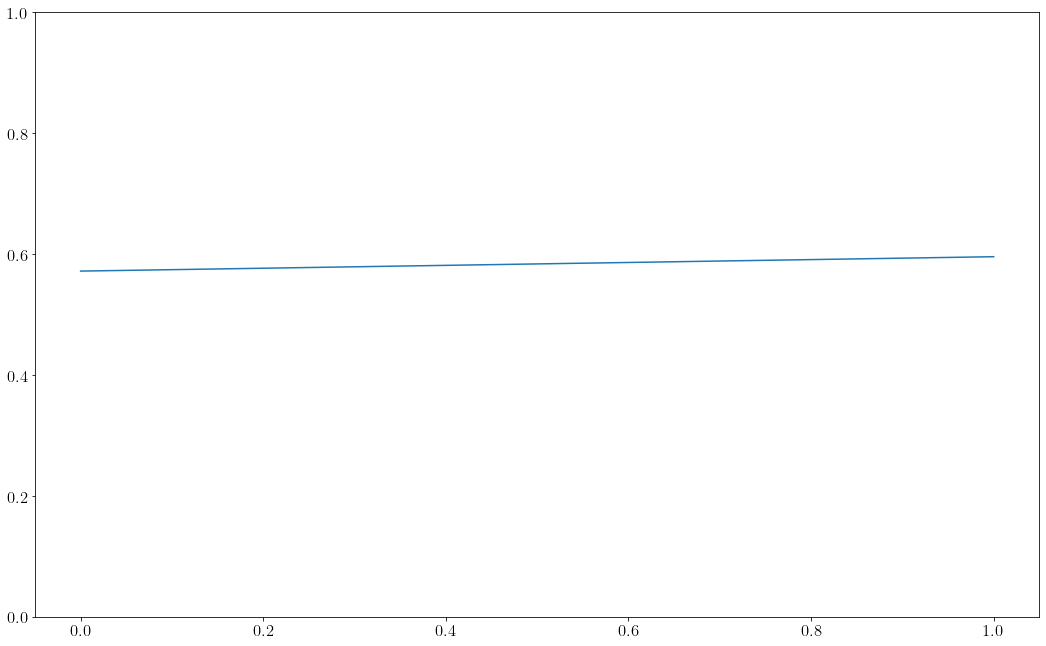

In [58]:
plt.plot(t,u_hat)
plt.ylim(0,1)

## Initialization comparison

In [8]:
class u(nn.Module):

    def __init__(self):
        super(u, self).__init__()

        self.net = nn.Sequential(
           nn.Linear(1,5),
           nn.ELU(),
           nn.Linear(5,5),
           nn.ELU(),
           nn.Linear(5,1)
        )
        #self.net = nn.Sequential(
        #   nn.Linear(1,5),
        #   nn.ELU(),
        #   nn.Linear(5,5),
        #   nn.ELU(),
        #   nn.Linear(5,1)
        #)
        #self.net = torch.nn.Parameter(torch.randn(()))

    def forward(self, t):
        return self.net(torch.tensor([float(t)]))#self.net#self.net(torch.tensor([float(t)]))

In [17]:
# customized settings
params = {  # 'backend': 'ps',
    'font.family': 'serif',
    'font.serif': 'Latin Modern Roman',
    'font.size': 7,
    'axes.labelsize': 'medium',
    'axes.titlesize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
    'savefig.dpi': 150,
    'text.usetex': True, 
    'legend.title_fontsize': 4}
# tell matplotlib about your params
rcParams.update(params)

# set nice figure sizes
fig_width_pt = 433.62 # Get this from LaTeX using \showthe\columnwidth
golden_mean = (np.sqrt(5.) - 1.) / 2.  # Aesthetic ratio
ratio = golden_mean
inches_per_pt = 1. / 72.27  # Convert pt to inches
fig_width = fig_width_pt * inches_per_pt  # width in inches
fig_height = fig_width*ratio  # height in inches
fig_size = [fig_width,fig_height]
rcParams.update({'figure.figsize': fig_size})

In [29]:
u_ast = lambda t: 0.851*np.exp(-t)
x_ast = lambda t: 0.851*np.sinh(t)

In [52]:
net_params_1 = net_params
trajectories_1 = trajectories

In [56]:
net_params_0 = net_params
trajectories_0 = trajectories

tensor([103.4835], grad_fn=<MulBackward0>)
tensor([100.1651], grad_fn=<MulBackward0>)


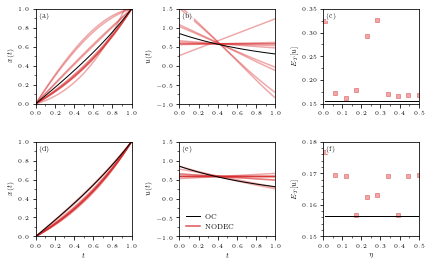

In [66]:
fig, ax = plt.subplots(ncols=3, nrows=2)
fig.patch.set_facecolor('white')

energies = []

text = ax[0,1].text(0.03,0.9*2.5-1,r"(b)")
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))

for i in range(len(net_params_1)):
    control_func = u()
    control_func.net = net_params_1[i]
    ax[0,1].plot(t,[control_func(x) for x in t],color='tab:red',alpha=0.4)
    energies.append(0.5*np.trapz([(control_func(x))**2 for x in t],t))

ax[0,1].plot(t,[u_ast(x) for x in t],color="k",label=r"OC",linewidth=1.)
ax[0,1].set_xlim([0,1])
ax[0,1].set_ylim([-1,1.5])
#ax[0,0].set_xlabel(r"$t$")
ax[0,1].set_ylabel(r"$u(t)$")
ax[0,1].xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax[0,1].yaxis.set_minor_locator(ticker.MultipleLocator(0.25))

ax[0,0].text(0.03,0.9,r"(a)")
for i in range(len(trajectories_1)):
    ax[0,0].plot(t,trajectories_1[i],color='tab:red',alpha=0.4)
ax[0,0].plot(t,[x_ast(x) for x in t],color="k",label=r"OC",linewidth=1.)
ax[0,0].set_xlim([0,1])
ax[0,0].set_ylim([0,1])
#ax[0,1].set_xlabel(r"$t$")
ax[0,0].set_ylabel(r"$x(t)$")
ax[0,0].xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax[0,0].yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

text = ax[0,2].text(0.03*0.5,0.9*0.2+0.15,r"(c)")
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))
ax[0,2].plot(learning_rates,energies,marker='s',markersize=4,alpha=0.4,color='tab:red',ls='None')
ax[0,2].plot(learning_rates,len(learning_rates)*[0.1565],linestyle='-',color='k',label=r"OC",linewidth=1.)
ax[0,2].set_xlim([0,0.5])
ax[0,2].set_ylim([0.15,0.35])
ax[0,2].set_yticks([0.15,0.2,0.25,0.3,0.35])
#ax[0,2].set_xlabel(r"$\eta$")
ax[0,2].set_ylabel(r"$E_T[u]$")
ax[0,2].xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax[0,2].yaxis.set_minor_locator(ticker.MultipleLocator(0.025))

print(min(energies)/0.1565*100)

energies = []

ax[1,1].text(0.03,2.5*0.9-1,r"(e)")
for i in range(len(net_params_0)):
    control_func = u()
    control_func.net = net_params_0[i]
    ax[1,1].plot(t,[control_func(x) for x in t],color='tab:red',alpha=0.4)
    energies.append(0.5*np.trapz([(control_func(x))**2 for x in t],t))

ax[1,1].plot(t,[u_ast(x) for x in t],color="k",linewidth=1.,label=r"OC")
ax[1,1].plot(10,10,color='tab:red',alpha=0.8,label=r"NODEC")
ax[1,1].set_xlim([0,1])
ax[1,1].set_ylim([-1,1.5])
ax[1,1].set_xlabel(r"$t$")
ax[1,1].set_ylabel(r"$u(t)$")
ax[1,1].legend(loc=3,frameon=False)
ax[1,1].xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax[1,1].yaxis.set_minor_locator(ticker.MultipleLocator(0.25))

ax[1,0].text(0.03,0.9,r"(d)")
for i in range(len(trajectories_0)):
    ax[1,0].plot(t,trajectories_0[i],color='tab:red',alpha=0.4)
ax[1,0].plot(t,[x_ast(x) for x in t],color="k",linewidth=1.,label=r"OC")
ax[1,0].set_xlim([0,1])
ax[1,0].set_ylim([0,1])
ax[1,0].set_xlabel(r"$t$")
ax[1,0].set_ylabel(r"$x(t)$")
ax[1,0].xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax[1,0].yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

text = ax[1,2].text(0.03*0.5,0.9*0.03+0.15,r"(f)")
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))
ax[1,2].plot(learning_rates,energies,marker='s',markersize=4,alpha=0.4,color='tab:red',ls='None')
ax[1,2].plot(learning_rates,len(learning_rates)*[0.1565],linestyle='-',color='k',label=r"OC",linewidth=1.)
ax[1,2].set_xlim([0,0.5])
ax[1,2].set_ylim([0.15,0.18])
ax[1,2].set_yticks([0.15,0.16,0.17,0.18])
ax[1,2].set_xlabel(r"$\eta$")
ax[1,2].set_ylabel(r"$E_T[u]$")
ax[1,2].xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax[1,2].yaxis.set_minor_locator(ticker.MultipleLocator(0.002))

print(min(energies)/0.1565*100)

plt.tight_layout()
plt.subplots_adjust(wspace=0.5,hspace=0.4)
plt.savefig("time_dependent_control.png",dpi=300)
plt.show()

## Analyzing implicit regularization

In [19]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib as mpl
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from matplotlib import rcParams

# customized settings
params = {  # 'backend': 'ps',
    'font.family': 'serif',
    'font.serif': 'Latin Modern Roman',
    'font.size': 7,
    'axes.labelsize': 'medium',
    'axes.titlesize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
    'savefig.dpi': 150,
    'text.usetex': True, 
    'legend.title_fontsize': 4}
# tell matplotlib about your params
rcParams.update(params)

# set nice figure sizes
fig_width_pt = 433.62 # Get this from LaTeX using \showthe\columnwidth
golden_mean = (np.sqrt(5.) - 1.) / 2.  # Aesthetic ratio
ratio = golden_mean
inches_per_pt = 1. / 72.27  # Convert pt to inches
fig_width = fig_width_pt * inches_per_pt  # width in inches
fig_height = fig_width*ratio  # height in inches
fig_size = [fig_width,0.5*fig_height]
rcParams.update({'figure.figsize': fig_size})

In [64]:
class ODE_func(nn.Module):

    def __init__(self):
        super(ODE_func, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(1,1),
            nn.ELU(),
            nn.Linear(6,6),
            nn.ELU(),
            nn.Linear(6,1)
        )
        self.net = torch.nn.Parameter(torch.tensor([1.0]))
        
    def forward(self, t, y):
        return y+self.net(torch.tensor([float(t)]))

def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.constant_(m.weight,val=0.1)#kaiming_uniform_(m.weight)
        torch.nn.init.constant_(m.bias,val=0.1)

In [6]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [4]:
trajectories = []
control_trajectories = []
net_params = []
eta=1e-2#0.15

energies = []

func = ODE_func()
#func.apply(weights_init)

#optimizer = optim.Adam(func.parameters(), lr=eta,betas=(0.9, 0.999))
optimizer = optim.SGD(func.parameters(), lr=eta)

best_model = func.net
loss_new = 1e9

theta_arr = []
dLdu_arr = []

for itr in range(1, 202):
    
    theta_arr.append(np.array(flatten([x.detach().numpy().flatten() for x in func.parameters()])))
    
    if itr % 1 == 0 or itr == 1:
        control_func = ODE_func(control_output=True)
        control_func.net = func.net
        control_trajectories.append([control_func(x,torch.tensor([0.0])) for x in t])
        energies.append(0.5*np.trapz([(control_func(x,torch.tensor([0.0])))**2 for x in t],t))
    
    optimizer.zero_grad()
    pred_x = odeint(func, true_x0, t, method='dopri5')
    loss = 0.5*torch.pow(pred_x[-1] - target_x,2)
    #loss = 0.5*torch.abs(pred_x[-1] - target_x)**2
    print(float(pred_x[-1]),float(target_x))
    dLdu_arr.append(float(pred_x[-1] - target_x))
    loss.backward()
    optimizer.step()

    if loss < loss_new:
        best_model = func.net
        loss_new = loss

    if itr % 20 == 0:
        with torch.no_grad():
            pred_x = odeint(func, true_x0, t, method='dopri5')
            loss = 0.5*torch.abs(pred_x[-1] - target_x)**2
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
    itr += 1

    net_params.append(best_model)
    trajectories.append(pred_x.detach().numpy())

NameError: name 'ODE_func' is not defined

In [343]:
-eta**-1*np.linalg.norm(theta_arr[1]-theta_arr[0])**2/dLdu_arr[0]

0.023224311910979897

In [46]:
control_trajectories_Adam = control_trajectories
theta_arr_Adam = theta_arr

In [49]:
control_trajectories_SGD = control_trajectories
theta_arr_SGD = theta_arr

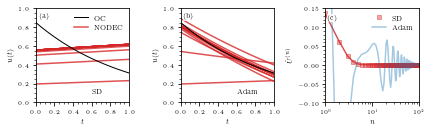

In [50]:
fig, ax = plt.subplots(ncols=3)
fig.patch.set_facecolor('white')

text = ax[0].text(0.03,0.9,r"(a)")
text2 = ax[0].text(0.6,0.1,r"SD")
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))
for i in range(len(control_trajectories_SGD[:20])):
    ax[0].plot(t,control_trajectories_SGD[i],'tab:red',alpha=0.8)

ax[0].plot(t,[u_ast(x) for x in t],color="k",linewidth=1.,label=r"OC",zorder=10)
ax[0].plot(10,10,color='tab:red',alpha=0.8,label=r"NODEC")
ax[0].legend(loc=1,frameon=False)

ax[0].set_xlim([0,1])
ax[0].set_ylim([0,1])
ax[0].xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax[0].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax[0].set_xlabel(r"$t$")
ax[0].set_ylabel(r"$u(t)$")

text = ax[1].text(0.03,0.9,r"(b)")
text2 = ax[1].text(0.6,0.1,r"Adam")
ax[1].plot(t,[u_ast(x) for x in t],color="k",linewidth=1.,label=r"optimal control",zorder=10)
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))
for i in range(len(control_trajectories_Adam)//10):
    ax[1].plot(t,control_trajectories_Adam[::10][i],'tab:red',alpha=0.8,zorder=1)

ax[1].set_xlim([0,1])
ax[1].set_ylim([0,1])
ax[1].xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax[1].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax[1].set_xlabel(r"$t$")
ax[1].set_ylabel(r"$u(t)$")

text = ax[2].text(1.1,0.9*0.3-0.15,r"(c)")
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))
ax[2].plot(np.arange(1,len(control_trajectories_SGD)),[-eta**-1*np.exp(-1.)*np.linalg.norm(theta_arr_SGD[j+1]-theta_arr_SGD[j])**2/(1e-9+dLdu_arr[j]) for j in range(len(control_trajectories_SGD)-1)],color='tab:red',alpha=0.8)
ax[2].plot(np.arange(1,len(control_trajectories_SGD)),[simps([float(control_trajectories_SGD[j+1][i]*np.exp(-t[i])) for i in range(len(t))],t)-simps([float(control_trajectories_SGD[j][i]*np.exp(-t[i])) for i in range(len(t))],t) for j in range(len(control_trajectories_SGD)-1)],marker='s',markersize=4,alpha=0.4,color='tab:red',ls='None',label=r'SD')
ax[2].plot(np.arange(1,len(control_trajectories_Adam)),[simps([float(control_trajectories_Adam[j+1][i]*np.exp(-t[i])) for i in range(len(t))],t)-simps([float(control_trajectories_Adam[j][i]*np.exp(-t[i])) for i in range(len(t))],t) for j in range(len(control_trajectories_Adam)-1)],ls='-',alpha=0.4,color='tab:blue',label=r'Adam')

ax[2].legend(loc=1,frameon=False)
ax[2].set_xlim([1e0,1e2])
ax[2].set_xscale('log')
ax[2].set_ylim([-0.1,0.15])
ax[2].set_yticks([-0.1,-0.05,0,0.05,0.1,0.15])
ax[2].yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
ax[2].set_xlabel(r"$n$")
ax[2].set_ylabel(r"$\hat{U}^{(n)}$")

plt.tight_layout()
plt.savefig("adam_vs_sgd.png",dpi=300)
plt.show()

In [17]:
from scipy.integrate import simps

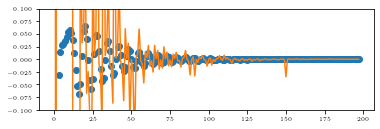

In [131]:
plt.plot([simps([float(control_trajectories[j+1][i]*np.exp(-t[i])) for i in range(len(t))],t)-simps([float(control_trajectories[j][i]*np.exp(-t[i])) for i in range(len(t))],t) for j in range(len(control_trajectories)-1)],'o')
plt.plot([-eta**-1*np.exp(-1.)*np.linalg.norm(theta_arr[j+1]-theta_arr[j])**2/dLdu_arr[j] for j in range(len(trajectories)-1)])
#plt.plot([-eta*0.359141*dLdu_arr[j] for j in range(len(trajectories)-1)])
#plt.plot([1/2*(theta_arr[j+1]-theta_arr[j]) for j in range(len(trajectories)-1)],'x')
#plt.plot([-eta*1/2*0.7182818284590451*(-1+0.7182818284590451*theta_arr[j]) for j in range(len(trajectories)-1)])
#plt.plot([1/2*(-1/2*eta*dLdu_arr[i]) for j in range(len(trajectories)-1)])
plt.ylim(-0.1,0.1)
plt.show()

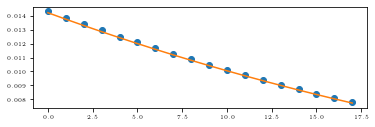

In [99]:
plt.plot([simps([float(control_trajectories[j+1][i]) for i in range(len(t))],t)-simps([float(control_trajectories[j][i]) for i in range(len(t))],t) for j in range(len(trajectories)-1)],'o')
plt.plot([-eta**-1*np.exp(-1.)/0.63212056*np.linalg.norm(theta_arr[j+1]-theta_arr[j])**2/dLdu_arr[j] for j in range(len(trajectories)-1)])
#plt.plot([-eta*0.359141*dLdu_arr[j] for j in range(len(trajectories)-1)])
#plt.plot([1/2*(theta_arr[j+1]-theta_arr[j]) for j in range(len(trajectories)-1)],'x')
#plt.plot([-eta*1/2*0.7182818284590451*(-1+0.7182818284590451*theta_arr[j]) for j in range(len(trajectories)-1)])
#plt.plot([1/2*(-1/2*eta*dLdu_arr[i]) for j in range(len(trajectories)-1)])
#plt.ylim(0.000330,0.000332)
plt.show()

In [80]:
np.mean(np.array([float(simps(control_trajectories[j+1],t))-float(simps(control_trajectories[j],t)) for j in range(len(trajectories)-1)])/np.array([-eta**-1*np.linalg.norm(theta_arr[j+1]-theta_arr[j])**2/float(dLdu_arr[j]) for j in range(len(trajectories)-1)]))

0.5859001251592726

In [240]:
class test(nn.Module):

    def __init__(self):
        super(test, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(1,1,bias=False)
        )
        
    def forward(self, t):
        return self.net(torch.tensor([float(t)]))

def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.constant_(m.weight,val=1)

In [163]:
eta=1e-2

func = test()
func.apply(weights_init)

optimizer = optim.SGD(func.parameters(), lr=eta)

for itr in range(1, 6):
    
    optimizer.zero_grad()
    pred_x = func.forward(10.0)
    
    weight = [float(x.detach().numpy()) for x in func.parameters()]
    print("weight:",weight[0])
    print("update:",weight[0] - eta*10*torch.abs(pred_x[-1] - torch.tensor([1])))
    loss = 0.5*torch.abs(pred_x[-1] - torch.tensor([1]))**2
    #loss = 0.5*torch.pow(pred_x[-1] - torch.tensor([1]),2)
    print("loss:",loss)
    loss.backward()
    optimizer.step()

NameError: name 'test' is not defined

In [445]:
float(np.trapz(control_trajectories[1],t)-np.trapz(control_trajectories[0],t))

0.00033334270119667053

In [444]:
-eta**-1*np.linalg.norm(theta_arr[1]-theta_arr[0])**2/dLdu_arr[0]

0.00047886546359782807

In [446]:
0.00033334270119667053/0.00047886546359782807

0.6961092969457203

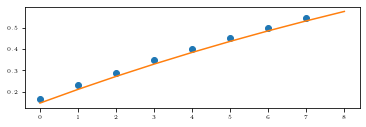

In [521]:
plt.figure()
plt.plot([theta_arr[i] for i in range(9)][1:],'o')
plt.plot([theta_arr[i]-1/2*eta*dLdu_arr[i] for i in range(9)])
#plt.ylim(0.1,0.105)
plt.show()

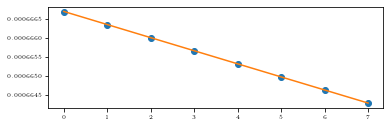

In [540]:
plt.figure()
plt.plot([theta_arr[i+1]-theta_arr[i] for i in range(8)],'o')
plt.plot([-1.0*eta*0.718282*(-1+0.718282*theta_arr[i]) for i in range(8)])
plt.show()

In [531]:
theta_arr[0:2]

[array([0.1], dtype=float32), array([0.10066669], dtype=float32)]

In [538]:
0.10066669-eta*0.7182818284590451*(-1 +0.7182818284590451*0.10066669)

0.10133303498538787

In [537]:
theta_arr

[array([0.1], dtype=float32),
 array([0.10066669], dtype=float32),
 array([0.10133303], dtype=float32),
 array([0.10199903], dtype=float32),
 array([0.10266469], dtype=float32),
 array([0.10333], dtype=float32),
 array([0.10399497], dtype=float32),
 array([0.1046596], dtype=float32),
 array([0.10532389], dtype=float32)]

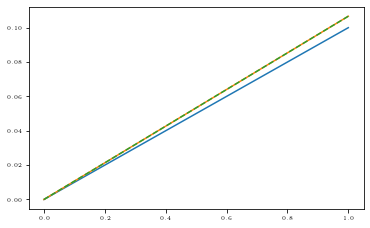

In [118]:
plt.figure()

plt.plot(t,control_trajectories[0])
plt.plot(t,np.array([float(control_trajectories[0][i]) for i in range(len(control_trajectories[0]))])+t.detach().numpy()*(theta_arr[1]-theta_arr[0]))
plt.plot(t,control_trajectories[1],'--')
#plt.plot(t,control_trajectories[4])
#plt.plot(t,control_trajectories[8])

plt.show()

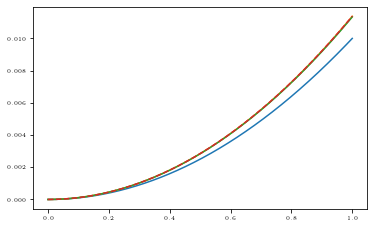

In [130]:
plt.figure()

plt.plot(t,[x**2 for x in control_trajectories[0]])
plt.plot(t,(np.array([float(control_trajectories[0][i]) for i in range(len(control_trajectories[0]))])+t.detach().numpy()*(theta_arr[1]-theta_arr[0]))**2)
plt.plot(t,(np.array([float(control_trajectories[0][i]) for i in range(len(control_trajectories[0]))]))**2+2*np.array([float(control_trajectories[0][i]) for i in range(len(control_trajectories[0]))])*t.detach().numpy()*(theta_arr[1]-theta_arr[0]))#+0.5*t.detach().numpy()**2*(theta_arr[1]-theta_arr[0])**2)
plt.plot(t,[x**2 for x in control_trajectories[1]],'--')
#plt.plot(t,control_trajectories[4])
#plt.plot(t,control_trajectories[8])

plt.show()

In [114]:
np.trapz(np.array([float(control_trajectories[0][i]) for i in range(len(control_trajectories[0]))])*t.detach().numpy()*(theta_arr[1]-theta_arr[0]),t)

2.2222858264100477e-05

In [115]:
np.trapz((np.array([float(control_trajectories[0][i]) for i in range(len(control_trajectories[0]))]))**2,t)+np.trapz(np.array([float(control_trajectories[0][i]) for i in range(len(control_trajectories[0]))])*t.detach().numpy()*(theta_arr[1]-theta_arr[0]),t)

0.00335555797679206

In [116]:
np.trapz((np.array([float(control_trajectories[1][i]) for i in range(len(control_trajectories[1]))]))**2,t)

0.0033779289741570615

In [65]:
integrate

[tensor([0.0500], grad_fn=<AddBackward0>),
 tensor([0.0533], grad_fn=<AddBackward0>),
 tensor([0.0566], grad_fn=<AddBackward0>),
 tensor([0.0599], grad_fn=<AddBackward0>),
 tensor([0.0632], grad_fn=<AddBackward0>),
 tensor([0.0665], grad_fn=<AddBackward0>),
 tensor([0.0697], grad_fn=<AddBackward0>),
 tensor([0.0730], grad_fn=<AddBackward0>),
 tensor([0.0762], grad_fn=<AddBackward0>)]

In [66]:
c = np.array([float(control_trajectories[0][i]) for i in range(len(control_trajectories[0]))])

In [67]:
eta*np.trapz(c*t.detach().numpy(),t)

0.0003333335060933149

In [75]:
float(integrate[0])-eta*np.trapz(c*t.detach().numpy(),t)*np.exp(1.)*np.trapz(t*np.exp(-t),t)*(np.exp(1.)*np.trapz(np.exp(-t)*c,t)-1)

0.05022222672464806

In [82]:
float(integrate[0])+np.trapz(c*t.detach().numpy(),t)*(theta_arr[1]-theta_arr[0])

array([0.05022223], dtype=float32)

In [52]:
bn = 1
ET = bn/2

In [53]:
eta = 1e-2
bn_arr = []
bn_arr.append(bn)

ET_arr = []
ET_arr.append(ET)

for i in range(201):
    bn_arr.append(bn_arr[i]-eta*(np.exp(1)-1)*(bn_arr[i]*(np.exp(1)-1)-1))
    ET_arr.append(ET_arr[i]-eta*bn_arr[i]*(np.exp(1)-1)*(bn_arr[i]*(np.exp(1)-1)-1))

In [74]:
dLdu_arr_Adam = dLdu_arr
theta_arr_Adam = theta_arr

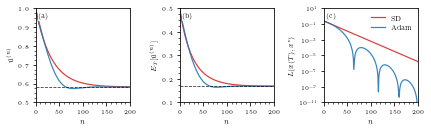

In [77]:
fig, ax = plt.subplots(ncols=3)
fig.patch.set_facecolor('white')

text = ax[0].text(0.03*200,0.9*0.5+0.5,r"(a)")
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))
ax[0].plot(bn_arr,label=r'${\mathrm{GD}}~b^{(n)}$',color='tab:red',alpha=0.9,linewidth=1.2)
ax[0].plot(theta_arr_Adam,label=r'${\mathrm{Adam}}~b^{(n)}$',color='tab:blue',alpha=0.9,linewidth=1.2)
ax[0].plot(1/(np.exp(1)-1)*np.ones_like(bn_arr),color='k',ls='--',linewidth=0.8,alpha=0.8)
#ax[0].legend(loc=1,frameon=False,ncol=2,handlelength=1.5)
ax[0].set_xlim(0,200)
ax[0].set_ylim(0.5,1)
ax[0].xaxis.set_minor_locator(ticker.MultipleLocator(10))
ax[0].yaxis.set_minor_locator(ticker.MultipleLocator(0.025))
ax[0].set_xlabel(r"$n$")
ax[0].set_ylabel(r"$\hat{u}^{(n)}$")

text = ax[1].text(0.03*200,0.9*0.4+0.1,r"(b)")
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))
ax[1].plot(ET_arr,label=r'${\mathrm{GD}}~E_T[\hat{u}]$',color='tab:red',alpha=0.9,linewidth=1.2)
ax[1].plot([x**2/2 for x in theta_arr_Adam],label=r'${\mathrm{Adam}}~E_T[\hat{u}]$',color='tab:blue',alpha=0.9,linewidth=1.2)
ax[1].plot(1/(np.exp(1)-1)**2/2*np.ones_like(bn_arr),color='k',ls='--',linewidth=0.8,alpha=0.8)
ax[1].set_xlim(0,200)
ax[1].set_ylim(0.1,0.5)
ax[1].set_yticks([0.1,0.2,0.3,0.4,0.5])
ax[1].xaxis.set_minor_locator(ticker.MultipleLocator(10))
ax[1].yaxis.set_minor_locator(ticker.MultipleLocator(0.025))
ax[1].set_xlabel(r"$n$")
ax[1].set_ylabel(r"$E_T[\hat{u}^{(n)}]$")

text = ax[2].text(0.03*200,0.07*1e1,r"(c)")
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))
ax[2].plot([0.5*x**2 for x in dLdu_arr],color='tab:red',alpha=0.9,linewidth=1.2,label=r"SD")
ax[2].plot([0.5*x**2 for x in dLdu_arr_Adam],color='tab:blue',alpha=0.9,linewidth=1.2,label=r"Adam")
ax[2].set_xlim(0,200)
ax[2].set_ylim(1e-11,1e1)
ax[2].xaxis.set_minor_locator(ticker.MultipleLocator(10))
ax[2].set_yscale('log')
ax[2].set_xlabel(r"$n$")
ax[2].set_ylabel(r"$L(x(T),x^*)$")
ax[2].legend(loc=1,frameon=False)

plt.tight_layout()
plt.savefig("descent_linear.png",dpi=300)
plt.show()